In [7]:
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
# Data generated from the mathematica script provided in the problem
data = pd.read_csv("cohomology_datapoints.csv")
x_data = data[['k1', 'k2']].values
y = data['h0'].values.reshape(-1, 1)

# Normalize inputs
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Dataset and DataLoader
class CohomologyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(CohomologyDataset(x_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(CohomologyDataset(x_test, y_test), batch_size=64)

In [10]:
# Neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.layers(x)

model = Net()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch   0 | Train Loss: 554178769.5238 | Val Loss: 7263581.3012
Epoch  10 | Train Loss: 289118997.7143 | Val Loss: 7263581.3012
Epoch  20 | Train Loss: 113947375.6190 | Val Loss: 7263581.3012
Epoch  30 | Train Loss: 52453598.7619 | Val Loss: 7263581.3012
Epoch  40 | Train Loss: 24174626.4286 | Val Loss: 7263581.3012
Epoch  50 | Train Loss: 13015123.9524 | Val Loss: 7263581.3012
Epoch  60 | Train Loss: 8796397.5476 | Val Loss: 7263581.3012
Epoch  70 | Train Loss: 7057053.9762 | Val Loss: 7263581.3012
Epoch  80 | Train Loss: 6022892.5357 | Val Loss: 7263581.3012
Epoch  90 | Train Loss: 5430764.2857 | Val Loss: 7263581.3012
Epoch 100 | Train Loss: 5011317.5357 | Val Loss: 7263581.3012
Epoch 110 | Train Loss: 4510861.0833 | Val Loss: 7263581.3012
Epoch 120 | Train Loss: 3834430.6071 | Val Loss: 7263581.3012
Epoch 130 | Train Loss: 3006808.1369 | Val Loss: 7263581.3012
Epoch 140 | Train Loss: 2134845.3393 | Val Loss: 7263581.3012
Epoch 150 | Train Loss: 1403591.4137 | Val Loss: 7263581.3012

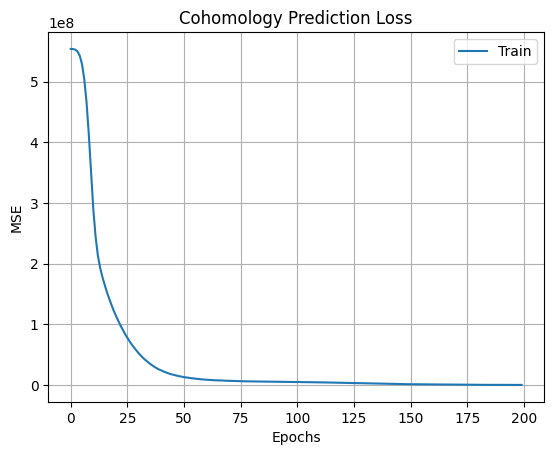

In [11]:
# Training
epochs = 200
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {train_losses[-1]:.4f}")

# Plot loss
plt.plot(train_losses, label="Train")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Cohomology Prediction Loss")
plt.grid(True)
plt.show()


In [12]:
### This is an interesting loss curve given the dataset is oddly biased towards h0 = 0

In [13]:
model.eval()
test_losses = []
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        print(f"Test Loss: {loss.item():.4f}")
        test_losses.append(loss.item())

Test Loss: 307906.1250
Test Loss: 207277.3281
Test Loss: 298000.2500
Test Loss: 264419.7500
Test Loss: 249778.3750
Test Loss: 168876.0312


In [ ]:
### PLotting our dataset because it is very non uniform (feature or bug??)

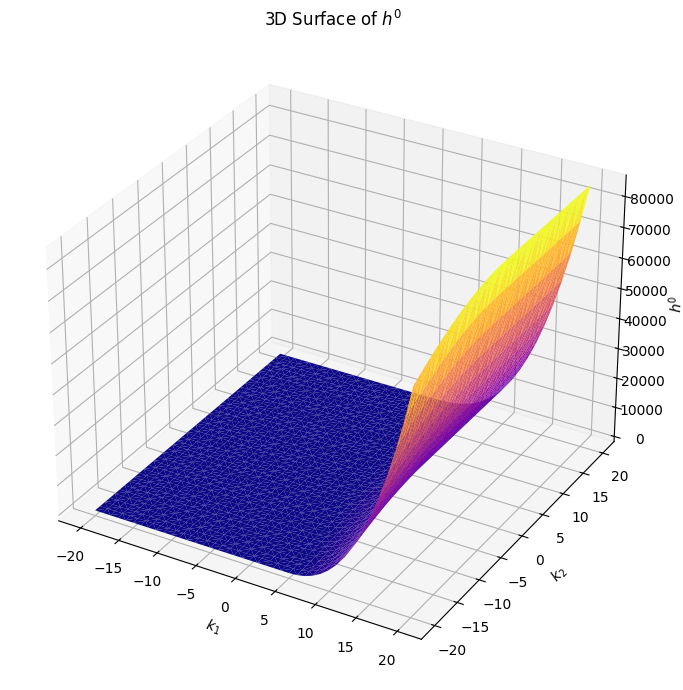

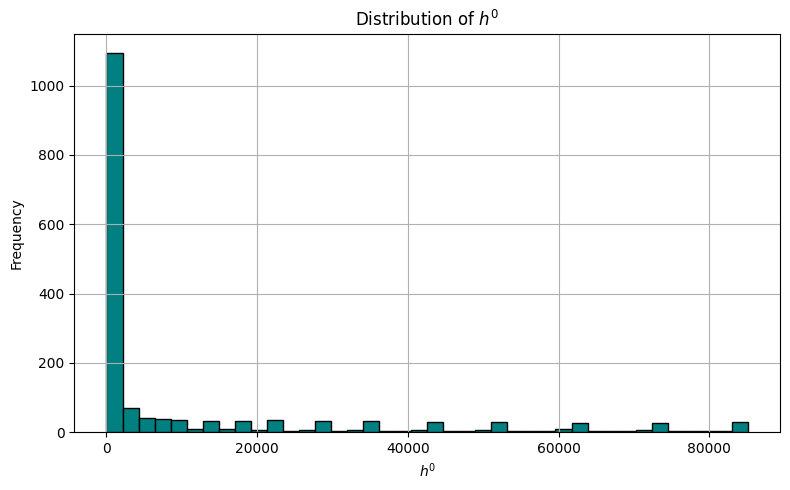

In [23]:
from matplotlib import cm

# Load data
data = pd.read_csv("cohomology_datapoints.csv")
data.columns = ['k1', 'k2', 'h0']

# Normalize if needed (optional)
scaler = StandardScaler()
data[['k1_norm', 'k2_norm']] = scaler.fit_transform(data[['k1', 'k2']])


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(data['k1'], data['k2'], data['h0'], cmap=cm.plasma, edgecolor='none')
ax.set_xlabel("$k_1$")
ax.set_ylabel("$k_2$")
ax.set_zlabel("$h^0$")
ax.set_title("3D Surface of $h^0$")
plt.tight_layout()

plt.figure(figsize=(8, 5))
plt.hist(data['h0'], bins=40, color='teal', edgecolor='black')
plt.title("Distribution of $h^0$")
plt.xlabel("$h^0$")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()


In [ ]:
### Seems like the reason it did so well was because all it had to learn was this simple slope (almost linear?) in the data?

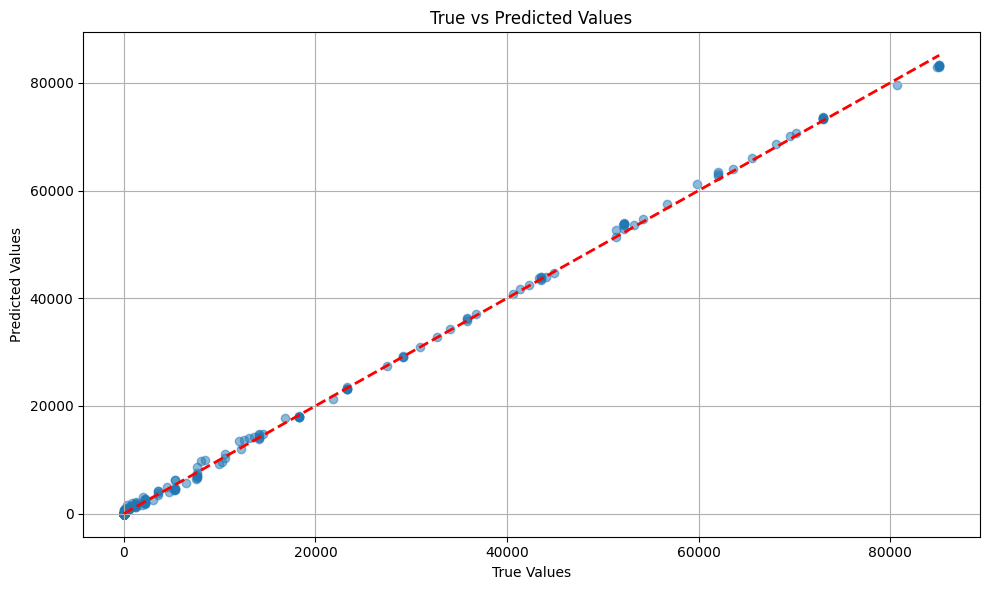

In [24]:
# plot the test vs predicted values
with torch.no_grad():
    y_pred = model(x_test).numpy()
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()